In [1]:
#put together each unit to create a complete pipeline 

In [1]:
# Imports
import torch
from PIL import Image
import os
import tempfile
import cv2
import subprocess
import re
import numpy as np
import io
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime, timedelta
from azure.storage.blob import BlobServiceClient
from dotenv import load_dotenv

In [2]:
# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
#model.to(device)

Using cache found in C:\Users\jacob/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-6-8 Python-3.12.3 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [3]:
def run_alpr(image_data):
    try:
        # Create a temporary file to store the image data
        with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as temp_img_file:
            temp_img_file.write(image_data)
            temp_img_path = temp_img_file.name
        
        command = [
            'alpr',
            '-c', 'us',
            '--topn', '1',
            temp_img_path  # Use the temporary file path here
        ]
        
        result = subprocess.run(command, capture_output=True, text=True, check=True)
        return result.stdout
    except subprocess.CalledProcessError as e:
        print(f"Error running alpr: {e}")
        return None
    finally:
        try:
            # Remove the temporary file after use
            if temp_img_path:
                os.remove(temp_img_path)
        except Exception as e:
            print(f"Error cleaning up temp file: {e}")

def process_image(image_path):
    #print(f"Processing image: {image_path}")
    alpr_output = run_alpr(image_path)
    if alpr_output:
        #print("ALPR Output:")
        return alpr_output
    else:
        print("No output from ALPR.")

In [4]:
def read_image_as_bytes(image):
    if image is None:
        # Create a blank image with a specified size and color (e.g., white)
        blank_image = Image.new('RGB', (100, 100), color = 'white')
        image = blank_image

    with io.BytesIO() as output:
        image.save(output, format='JPEG')  # Adjust format as needed ('JPEG', 'PNG', etc.)
        image_bytes = output.getvalue()
    return image_bytes

In [5]:
def Yolov5_Detection(img):

    results = model(img) #Full image

    #Makes more sense: Dont want to be passing in location of image each time rather just the image!
    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)  # Assuming img is a numpy array or similar format

    #if isinstance(img, Image.Image):
        #img = Image.open(img) #Or error

    # Initialize variables
    cropped_image = None
    confidence = None
    label = None

    boxes = results.xyxy[0]  # Get the bounding box coordinates for the image
    for result in boxes: 

        x1, y1, x2, y2, conf, cls = result  # Bounding box coordinates, confidence, and class index
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        bounding_box_cs = [x1, y1, x2, y2] #NEW
    
        label = results.names[int(cls)]  # Get the class name using the class index
        confidence = conf.item() #Get confidence
        cropped_image = img.crop((x1, y1, x2, y2)) #get cropped image
        
    return  results, cropped_image, confidence, label

In [6]:
def extract_frames(video_path):
    # List to store frames
    frames = []
    
    # Load the video
    video = cv2.VideoCapture(video_path)
    success, frame = video.read()

    # Read until the end of the video
    while success:
        # Append the frame to the list
        frames.append(frame)
        # Read the next frame
        success, frame = video.read()
    
    # Release the video object
    video.release()

    return frames

In [7]:
def Driver(feed): #
    #feed = 'C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\TEST_PHOTOS\\TEST1.jpg'
    #feed = Image
    yolo_det = Yolov5_Detection(feed) #Takes a frame from feed

    cropped_image = yolo_det[1] #Only grab the inner bounding box

    #OpenALPR to read license plate
    OpenALPR = process_image(read_image_as_bytes(cropped_image))
    #OpenALPR = extract_plate_info(OpenALPR) #Create this function later and ensure it matches all possible outputs

    return yolo_det, OpenALPR

In [8]:
def alpr_detection(feed):
    OpenALPR = process_image(read_image_as_bytes(cropped_image))
    return OpenALPR
    

In [9]:
def extract_plate_info(output_str):
    if "No license plates found." in output_str:
        return ["", 0.0]
    
    # Split the output string by lines
    lines = output_str.strip().split('\n')
    
    # Extract the license plate and confidence from the first line
    plate_info_line = lines[1].strip()
    
    # Extract plate number and confidence
    plate_number = plate_info_line.split('- ')[-1].split('\t')[0].strip()
    confidence_str = plate_info_line.split('confidence: ')[-1].strip()
    confidence = float(confidence_str[:-1])  # Remove the trailing '\n' and convert to float
    
    return [plate_number, round(confidence, 1)]

In [10]:
def most_common_license_plate(lst):
    # Extract the license plates (first element) from each inner list, excluding empty strings
    license_plates = [sublist[0] for sublist in lst if sublist[0]]
    
    # Count occurrences of each license plate
    counts = Counter(license_plates)
    
    # Get the most common license plate and its count
    most_common = counts.most_common(1)
    
    # Check if there is at least one non-empty license plate
    if most_common:
        most_common_license_plate = most_common[0][0]
    else:
        most_common_license_plate = None  # or you can handle it differently if needed
    
    return most_common_license_plate

In [11]:
def yolov5_results_to_numpy(results):
    # Show the results using Matplotlib
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(np.squeeze(results.render()[0]))
    ax.axis('off')  # Hide axes
    plt.tight_layout()

    # Convert the Matplotlib figure to a NumPy array
    fig.canvas.draw()
    image_np = np.array(fig.canvas.renderer._renderer)
    plt.close(fig)  # Close the Matplotlib figure to free memory

    return image_np

In [12]:
def display_numpy_image(image_np):
    # Convert NumPy array to PIL Image
    image_pil = Image.fromarray(image_np)

    # Display the PIL Image in Jupyter Notebook
    display(image_pil)

In [13]:
def create_video(images, output_video_path, fps=24):
    # Determine the shape of the images (assuming all have the same shape)
    height, width, _ = images[0].shape

    # Initialize VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Write each frame to the video
    for image in images:
        # Convert RGB to BGR (OpenCV uses BGR)
        frame_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)

    # Release the VideoWriter and close all OpenCV windows
    out.release()
    cv2.destroyAllWindows()

In [14]:
def get_video_timestamps(video_path, start_time=None):
    # Load the video file
    video = cv2.VideoCapture(video_path)

    # Get the frame rate of the video
    fps = video.get(cv2.CAP_PROP_FPS)

    # If start_time is not provided, use the current datetime
    if start_time is None:
        start_time = datetime.now()

    timestamps = []

    # Loop through the video frames
    while True:
        ret, frame = video.read()
        if not ret:
            break

        # Get the current frame number
        frame_number = int(video.get(cv2.CAP_PROP_POS_FRAMES))
        
        # Calculate the timestamp (date and time) for the current frame
        timestamp = start_time + timedelta(seconds=(frame_number / fps))

        # Store the timestamp (and optionally the frame)
        timestamps.append((frame_number, timestamp))

        # Optionally: Process the frame here or save it
        # e.g., cv2.imwrite(f'frame_{frame_number}.jpg', frame)

    video.release()
    return timestamps

In [15]:
def check_same(lst):
    """
    Checks if the first 5 elements of the list are the same.
    
    Parameters:
    - lst: A list of numbers.
    
    Returns:
    - The first element if the first 5 elements are the same, otherwise 0.
    """
    if len(lst) < 5:
        return 0  # Not enough elements to check

    first_five = lst[:5]
    
    # Check if all first 5 elements are the same
    if len(set(first_five)) == 1:
        return first_five[0]
    
    return 0

In [16]:
def labeler(number):
    if number == 1:
        return 'car'
    elif number == 2:
        return 'person'
    else:
        return 'none'

In [17]:
def blob_data_lp(det_lst):

    if det_lst[0] == 'car':
        lp_field = read_lp(det_lst)
        
    else:
       lp_field = 'none'

    return lp_field

In [18]:
def video_det(det):
    complete_vid = []
    for i in range(len(det)):
        complete_vid.append(yolov5_results_to_numpy(det[i][2][0]))
    return complete_vid  

In [19]:
def read_lp(det_blob):

    det_slice_test = det_blob[1]

    #run license plates for the car instance
    car_det_lp = []
    for i in range(len(det_slice_test)):
        cropped_image = det_slice_test[i][2][1] #Only grab the inner bounding box
        
        #OpenALPR to read license plate
        OpenALPR = extract_plate_info(process_image(read_image_as_bytes(cropped_image)))
    
        car_det_lp.append(OpenALPR)
        #print(OpenALPR)
    
    #add licence plate to all car detections
    car_det_lp_final = most_common_license_plate(car_det_lp)

    return car_det_lp_final

In [20]:
class ListSplitter:
    def __init__(self):
        self.current_chunk = []
        self.ones_streak = 0
        self.zeros_streak = 0
        self.twos_streak = 0
        self.inside_chunk = False
        self.result = []

    def process_element(self, element):
        self.current_chunk.append(element)

        # Check for streaks of 1s, 2s, or 0s
        if element == 1:
            self.ones_streak += 1
            self.zeros_streak = 0
            self.twos_streak = 0
        elif element == 2:
            self.twos_streak += 1
            self.ones_streak = 0
            self.zeros_streak = 0
        elif element == 0:
            self.zeros_streak += 1
            self.ones_streak = 0
            self.twos_streak = 0

        # Start a chunk when we have a streak of 5 ones or twos
        if (self.ones_streak == 5 or self.twos_streak == 5) and not self.inside_chunk:
            self.inside_chunk = True

        # End a chunk when we have a streak of 5 zeros
        if self.zeros_streak == 5 and self.inside_chunk:
            completed_chunk = self.current_chunk[:-5]
            self.result.append(completed_chunk)
            self.current_chunk = self.current_chunk[-5:]
            self.inside_chunk = False
            return completed_chunk

        # End a chunk when we have a streak of 5 ones or 5 twos
        if (self.ones_streak == 5 or self.twos_streak == 5) and self.inside_chunk:
            completed_chunk = self.current_chunk[:-5]
            self.result.append(completed_chunk)
            self.current_chunk = self.current_chunk[-5:]
            self.inside_chunk = True
            return completed_chunk

        return None  # No chunk completed yet

    def finalize(self):
        if self.current_chunk:
            self.result.append(self.current_chunk)
            return self.current_chunk
        return None

# Example usage
splitter = ListSplitter()

input_list =  [0,0,0,0,0,0,0,0,0,0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0,0,0,0,0,0,0,0,1,0,0,0,0,0,0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,2,2,2,2,2,2,2,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,2,1,1,0,0,0,0,2,0,0,0,0,0,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1]
#input_list  = lst
# Process elements one at a time
for elem in input_list:
    result = splitter.process_element(elem)
    if result is not None:
        print(f"Chunk completed: {result}")
        print(labeler(check_same(result)))

# Finalize to get the last chunk
final_chunk = splitter.finalize()
if final_chunk is not None:
    print(f"Final chunk: {final_chunk}")
    print(labeler(check_same(final_chunk)))

Chunk completed: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
none
Chunk completed: [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
car
Chunk completed: [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
none
Chunk completed: [1, 1, 1, 1, 1, 1, 0, 2, 1]
car
Chunk completed: [2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
person
Chunk completed: [2, 2, 2, 2, 2, 2, 2]
person
Chunk completed: [0, 0, 0, 0, 0]
none
Chunk completed: [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 0, 0, 0, 0, 2]
car
Chunk completed: [0, 0, 0, 0, 0]
none
Chunk completed: [2, 2, 2, 2, 2, 2]
person
Chunk completed: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
car
Final chunk: [1, 1, 1, 1, 1, 1, 1, 1]
car


In [21]:
##TESTING THIS FOR SPLIT ISSUE! 

class ListSplitter:
    def __init__(self):
        self.current_chunk = []
        self.ones_streak = 0
        self.zeros_streak = 0
        self.twos_streak = 0
        self.inside_chunk = False
        self.result = []

    def process_element(self, element):
        self.current_chunk.append(element)

        # Check for streaks of 1s, 2s, or 0s
        if element == 1:
            self.ones_streak += 1
            self.zeros_streak = 0
            self.twos_streak = 0
        elif element == 2:
            self.twos_streak += 1
            self.ones_streak = 0
            self.zeros_streak = 0
        elif element == 0:
            self.zeros_streak += 1
            self.ones_streak = 0
            self.twos_streak = 0

        # Start a chunk when we have a streak of 5 ones or twos
        if (self.ones_streak == 5 or self.twos_streak == 5) and not self.inside_chunk:
            self.inside_chunk = True

        # Split the chunk only when we have 5 consecutive zeros
        if self.zeros_streak == 5 and self.inside_chunk:
            completed_chunk = self.current_chunk[:-5]
            self.result.append(completed_chunk)
            self.current_chunk = self.current_chunk[-5:]
            self.inside_chunk = False
            return completed_chunk

        # End a chunk when we have a streak of 5 ones or 5 twos
        if (self.ones_streak == 5 or self.twos_streak == 5) and self.inside_chunk:
            completed_chunk = self.current_chunk[:-5]
            self.result.append(completed_chunk)
            self.current_chunk = self.current_chunk[-5:]
            self.inside_chunk = True
            return completed_chunk

        return None  # No chunk completed yet

    def finalize(self):
        if self.current_chunk:
            self.result.append(self.current_chunk)
            return self.current_chunk
        return None

# Example usage
splitter = ListSplitter()
combined_data = []
data = []

#input_list =  [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,2,1,1,0,0,0,0,2,0,0,0,0,0,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1]
#input_list =  [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0,0,0,0,0,0,0,0,1,0,0,0,0,0,0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,2,2,2,2,2,2,2,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,2,1,1,0,0,0,0,2,0,0,0,0,0,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1]
#FINAL ONE WE HAVE BEEN USING#input_list =  [0,0,0,0,0,0,0,0,0,0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0,0,0,0,0,0,0,0,1,0,0,0,0,0,0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,2,2,2,2,2,2,2,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,2,1,1,0,0,0,0,2,0,0,0,0,0,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1]
input_list =  [0,0,0,1, 1, 1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,1,1,1,1,1,1,1,0,1,1,1,1,1,2,2,2,2,2,0,2,2,2,2,2,2,2]
#input_list  = lst


check_lst = [['none', []]]
len_count = []
test_lst_V2 = []
new_counter = 0
index_count = 0
len_check_lst = 0
start_index = 0


for elem in input_list:
    result = splitter.process_element(elem)
    if result is not None:
        chunk = result
        label = labeler(check_same(result))
        
        if chunk:

             combined_data.append([label,chunk])
    
             if combined_data[index_count][0] == check_lst[-1][0]:
                # Extend the previous list with the current list
                 check_lst[-1][1].extend(combined_data[index_count][1]) ##If it extends the list need to remove the previous version until we move onto #a new element! make a same counter set to 0 once its free and push into the final list!  
             else:
                # If different, add the current element to the result list
                 check_lst.append(combined_data[index_count])

             test_lst_V2.append(check_lst[-1])
             len_check_lst = len(check_lst)
             len_count.append(len_check_lst)
            
             if len_count[index_count] > len_count[index_count - 1]:
                print(test_lst_V2[index_count-1])#Send to Azure
                print(len(test_lst_V2[index_count-1][1]))#len test
                print(test_lst_V2[index_count-1][0]) #object test

                #Testing index functionallity 
                length = len(test_lst_V2[index_count-1][1])
                end_index = start_index + length
                print(f'{start_index}:{end_index}')
                start_index = end_index
            
              

             index_count = index_count + 1
        


current_end_lst = check_lst[-1]   
check_lst_2 = check_lst[-1][0]
     
# Finalize to get the last chunk
final_chunk = splitter.finalize()
if final_chunk is not None:
    chunk = final_chunk
    label = labeler(check_same(final_chunk))
    combined_data.append([label,chunk])

    if combined_data[-1][0] == check_lst_2:
        # Extend the previous list with the current list
        check_lst[-1][1].extend(combined_data[index_count][1])
        print(check_lst[-1])#send to Azure
        print(len(check_lst[-1][1]))##NEW len test

        #Testing index functionallity 
        length = len(check_lst[-1][1])
        end_index = start_index + length
        print(f'{start_index}:{end_index}')
        start_index = end_index



    
        
    else:
        # If different, add the current element to the result list
        print(current_end_lst) #Send to Azure
        print(len(current_end_lst[1]))#len test

        #Testing index functionallity 
        length = len(current_end_lst[1])
        end_index = start_index + length
        print(f'{start_index}:{end_index}')
        start_index = end_index
        
        
        check_lst.append(combined_data[index_count])
        print(check_lst[-1]) #Send to Azure
        print(len(check_lst[-1][1]))#len test

        #Testing index functionallity 
        length = len(check_lst[-1][1])
        end_index = start_index + length
        print(f'{start_index}:{end_index}')
        start_index = end_index


#NOW NEED TO CHANGE THE 1S AND 0S TO REAL DETECTION DATA!!
#Figure out how to add indexes to this 

#look at the indexing mistake here
#Check if this error also occurs to other similar gaps! 

#End of friday complete this error and all the input code
#Weekend send full video and run some tests to make sure its going in correctly! 




['none', [0, 0, 0]]
3
none
0:3
['car', [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]]
19
car
3:22
['person', [2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2]]
24
person
22:46
['car', [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]]
13
car
46:59
['person', [2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2]]
13
59:72


In [209]:
input_list =  [1, 1, 1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,1,1,1,1,1,1,1,0,1,1,1,1,1,2,2,2,2,2,2]
input_list[56:62]

[2, 2, 2, 2, 2, 2]

In [22]:
video_path = "C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\Data\\DSCN1162.mp4"
frames = extract_frames(video_path)
timestamps = get_video_timestamps(video_path)

In [33]:
##Add real car feed into mix

class ListSplitter:
    def __init__(self):
        self.current_chunk = []
        self.ones_streak = 0
        self.zeros_streak = 0
        self.twos_streak = 0
        self.inside_chunk = False
        self.result = []

    def process_element(self, element):
        self.current_chunk.append(element)

        # Check for streaks of 1s, 2s, or 0s
        if element == 1:
            self.ones_streak += 1
            self.zeros_streak = 0
            self.twos_streak = 0
        elif element == 2:
            self.twos_streak += 1
            self.ones_streak = 0
            self.zeros_streak = 0
        elif element == 0:
            self.zeros_streak += 1
            self.ones_streak = 0
            self.twos_streak = 0

        # Start a chunk when we have a streak of 5 ones or twos
        if (self.ones_streak == 5 or self.twos_streak == 5) and not self.inside_chunk:
            self.inside_chunk = True

        # Split the chunk only when we have 5 consecutive zeros
        if self.zeros_streak == 5 and self.inside_chunk:
            completed_chunk = self.current_chunk[:-5]
            self.result.append(completed_chunk)
            self.current_chunk = self.current_chunk[-5:]
            self.inside_chunk = False
            return completed_chunk

        # End a chunk when we have a streak of 5 ones or 5 twos
        if (self.ones_streak == 5 or self.twos_streak == 5) and self.inside_chunk:
            completed_chunk = self.current_chunk[:-5]
            self.result.append(completed_chunk)
            self.current_chunk = self.current_chunk[-5:]
            self.inside_chunk = True
            return completed_chunk

        return None  # No chunk completed yet

    def finalize(self):
        if self.current_chunk:
            self.result.append(self.current_chunk)
            return self.current_chunk
        return None

# Example usage
splitter = ListSplitter()
combined_data = []
data = []

#input_list =  [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,2,1,1,0,0,0,0,2,0,0,0,0,0,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1]
#input_list =  [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0,0,0,0,0,0,0,0,1,0,0,0,0,0,0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,2,2,2,2,2,2,2,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,2,1,1,0,0,0,0,2,0,0,0,0,0,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1]
#FINAL ONE WE HAVE BEEN USING#input_list =  [0,0,0,0,0,0,0,0,0,0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0,0,0,0,0,0,0,0,1,0,0,0,0,0,0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,2,2,2,2,2,2,2,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,2,1,1,0,0,0,0,2,0,0,0,0,0,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1]
#input_list =  [1, 1, 1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,1,1,1,1,1,1,1,0,1,1,1,1,1,2,2,2,2,2,2]
input_list  = frames


check_lst = [['none', []]]
len_count = []
test_lst_V2 = []
new_counter = 0
index_count = 0
count = 0
len_check_lst = 0
start_index = 0
#yolo_det = []
detection_data_frame = []
test_final = []



#Tetsing functionality delete later
det_slice_totals = []


for elem in input_list:

    yolo = Yolov5_Detection(elem)
    #yolo_det.append(yolo)
    object = yolo[3]

    frame_number, timestamp = timestamps[count]
    detection_data = [frame_number,timestamp.strftime('%Y-%m-%d %H:%M:%S.%f'),yolo]
    detection_data_frame.append(detection_data)
    count = count + 1

    if object == 'car':
        object_num = 1
    elif object == 'person':
        object_num = 2
    else:
        object_num = 0



    
    result = splitter.process_element(object_num)
    if result is not None:
        chunk = result
        label = labeler(check_same(result))
        
        if chunk:

             combined_data.append([label,chunk])
    
             if combined_data[index_count][0] == check_lst[-1][0]:
                # Extend the previous list with the current list
                 check_lst[-1][1].extend(combined_data[index_count][1]) ##If it extends the list need to remove the previous version until we move onto                                                             #a new element! make a same counter set to 0 once its free and push into the final list!  
             else:
                # If different, add the current element to the result list
                 check_lst.append(combined_data[index_count])

             test_lst_V2.append(check_lst[-1])
             len_check_lst = len(check_lst)
             len_count.append(len_check_lst)
            
             if len_count[index_count] > len_count[index_count - 1]:
                print(test_lst_V2[index_count-1])#Send to Azure!!!!
                print(len(test_lst_V2[index_count-1][1]))#len test
                 
                #Get object here
                obj_res = test_lst_V2[index_count-1][0]

                #Index functionallity 
                length = len(test_lst_V2[index_count-1][1])
                end_index = start_index + length

                #Indexing detection data
                det_slice = [obj_res, detection_data_frame[start_index:end_index]]
                Azure_Push(det_slice)
                start_index = end_index      
            

             index_count = index_count + 1
        


current_end_lst = check_lst[-1]   
check_lst_2 = check_lst[-1][0]
     
# Finalize to get the last chunk
final_chunk = splitter.finalize()
if final_chunk is not None:
    chunk = final_chunk
    label = labeler(check_same(final_chunk))
    combined_data.append([label,chunk])

    if combined_data[-1][0] == check_lst_2:
        # Extend the previous list with the current list
        check_lst[-1][1].extend(combined_data[index_count][1])
        print(check_lst[-1])#send to Azure!!!!!!
        print(len(check_lst[-1][1]))#len test
        
        #Get object here
        obj_res = check_lst[-1][0]

        #Testing index functionallity 
        length = len(check_lst[-1][1])
        end_index = start_index + length
        det_slice = [obj_res, detection_data_frame[start_index:end_index]]
        Azure_Push(det_slice)
        print(det_slice)

        det_slice_totals.append(det_slice)

        
        #print(f'{start_index}:{end_index}')
        start_index = end_index
        

    
    else:
        # If different, add the current element to the result list
        print(current_end_lst) #Send to Azure!!!!!!!
        print(len(current_end_lst[1]))#len test

        #Get object here
        obj_res = current_end_lst[0]

        #Testing index functionallity 
        length = len(current_end_lst[1])
        end_index = start_index + length
        det_slice = [obj_res, detection_data_frame[start_index:end_index]]
        print(det_slice)
        Azure_Push(det_slice)
        det_slice_totals.append(det_slice)
        #print(f'{start_index}:{end_index}')
        start_index = end_index

        
        check_lst.append(combined_data[index_count])
        print(check_lst[-1]) #Send to Azure!!!!!!!
        print(len(check_lst[-1][1]))#len test
        
        #Get object here
        obj_res = check_lst[-1][0]

        #Testing index functionallity 
        length = len(check_lst[-1][1])
        end_index = start_index + length
        det_slice = [obj_res, detection_data_frame[start_index:end_index]]
        print(det_slice)
        Azure_Push(det_slice)
        det_slice_totals.append(det_slice)
        #print(f'{start_index}:{end_index}')
        start_index = end_index


#NOW NEED TO CHANGE THE 1S AND 0S TO REAL DETECTION DATA!!

#Just need to add the last  piece by indexing the detection
#Check out the code to make sure it comes out together! 


    

['none', [0, 0, 1, 0, 0]]
5
Video with metadata uploaded as none_2024-09-22 13-22-16-738249_to_2024-09-22 13-22-16-871535.mp4
['car', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
282
['car', [[6, '

In [ ]:
#form = [object,min frame, max frame, min ts, max ts, license plate = yes(run detection) or no = none, full video 

In [24]:
#Actual process: 
blob = det_slice_totals[0] #here is the detection blob, change [x] to the desired detection number
#replace with the actual blob that is created

In [32]:
def Azure_Push(blob):
    
    object = blob[0]
    min_frame = blob[1][0][0]
    max_frame= blob[1][-1][0]
    min_ts = blob[1][0][1]
    max_ts= blob[1][-1][1]
    license_plate = blob_data_lp(blob)
    
    #create video and save to a location for now
    det = blob[1]
    image_list = video_det(det)
    output_video_path = 'C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\FINAL_PROJECT\\Data\\Temporary_Video.mp4'
    create_video(image_list, output_video_path)
    
    data_output = [object,min_frame,max_frame,min_ts,max_ts,license_plate,output_video_path]

    # Load environment variables from .env file
    load_dotenv(dotenv_path='C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\FINAL_PROJECT\\Azure_Credentials.env')
    
    # Fetch connection string and container name from environment variables
    connection_string = os.getenv('AZURE_CONNECTION_STRING')
    container_name = os.getenv('AZURE_CONTAINER_NAME')
    
    # BlobServiceClient instance
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)
    container_client = blob_service_client.get_container_client(container_name)
    
    # Sample data
    #detection_results = data_output
    
    # Metadata for the blob
    metadata = {
        'object_detected': data_output[0],
        'start_frame': str(data_output[1]),
        'end_frame': str(data_output[2]),
        'start_time': data_output[3],
        'end_time': data_output[4],
        'license_plate': data_output[5],
    }
    
    # Video path and blob name
    video_path = data_output[6]
    
    # Create a dynamic video name using license plate and timestamps
    obj_det = data_output[0]
    start_time = data_output[3].replace(":", "-").replace(".", "-")
    end_time = data_output[4].replace(":", "-").replace(".", "-")
    video_name = f"{obj_det}_{start_time}_to_{end_time}.mp4"
    
    
    # Upload video file with metadata
    blob_client = container_client.get_blob_client(video_name)
    
    with open(video_path, "rb") as video_file:
        blob_client.upload_blob(video_file, metadata=metadata, overwrite=True)
    #print(f"Video with metadata uploaded as {video_name}")


In [ ]:
#create a function where I pass in a list and I get:
#min,max,video compressed, license plate
#now pass det_slice into a new function that turns it into a final aws form 
#form = [object,min frame, max frame, min ts, max ts, license plate = yes(run detection) or no = none, full video 

In [29]:
car_det_lp_final = det_slice_totals[1]

In [38]:
test = car_det_lp_final[1]

In [33]:
print(read_lp(car_det_lp_final))

None


In [ ]:
#need to put together and save a video temporarily to send into AZURE
#or should I keep it a list of frames and then AZURE function converts it? 

In [ ]:
#Strat: make continous list of vehicle detections
#Then at every print and send to Azure statement take the indexes then index the detection list!

#may need to send through the final blob after multiple steps of proccessing 
#First would need to follow the abve detection outline)

In [ ]:
#get_video_timestamps
#video_path = "C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\Data\\DSCN1162.mp4"
#frames = extract_frames(video_path)


In [88]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [48]:
#Create engine to identify and group these spots
car_det = detection_data[0:287]
empty_det = detection_data[287:-1]

In [49]:
car_det

[298,
 '2024-09-19 20:36:19.457904',
 (YOLOv5 <class 'models.common.Detections'> instance
  image 1/1: 720x1280 (no detections)
  Speed: 1.0ms pre-process, 7.0ms inference, 0.0ms NMS per image at shape (1, 3, 384, 640),
  None,
  None,
  None)]

In [131]:
#Final Package
#Car_Blob = [min timestamp , max timestamp , object = car, license plate, video ] 
min_ts = car_det[0][1]
max_ts = car_det[-1][1]
temp_video = 'C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\FINAL PROJECT\\Data\\Test2.mp4'
car_blob = [min_ts,max_ts,'car',car_det_lp_final, temp_video]

In [132]:
car_blob

['2024-08-29 12:00:00.033322',
 '2024-08-29 12:00:09.563320',
 'car',
 'CBKP984',
 'C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\FINAL PROJECT\\Data\\Test2.mp4']

In [137]:
#empty blob //send after the first detection! 
#Save all the images to a video and test the video
image_list = video_det(empty_det)
output_video_path = 'C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\FINAL PROJECT\\Data\\Test3.mp4'
create_video(image_list, output_video_path)

In [140]:
min_ts_e = empty_det[0][1]
max_ts_e = empty_det[-1][1]
temp_video2 = 'C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\FINAL PROJECT\\Data\\Test3.mp4'
car_blob_e = [min_ts_e,max_ts_e,'none','none', temp_video2]

In [141]:
car_blob_e

['2024-08-29 12:00:09.596641',
 '2024-08-29 12:00:09.896536',
 'none',
 'none',
 'C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\FINAL PROJECT\\Data\\Test3.mp4']

In [145]:
from azure.storage.blob import BlobServiceClient
import os

# Your connection string and container name
connection_string = "DefaultEndpointsProtocol=https;AccountName=blobalpr;AccountKey=2w19F8n71k97Iip9iWva8xG2ohxwQewIziN/y8bzhKAbbvpvBBBaBjMnTWHzY5WI5t8bdJwvxz+8+AStOTG58A==;EndpointSuffix=core.windows.net"
container_name = "carvideo1"

# BlobServiceClient instance
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

# Sample data
detection_results = ['2024-08-29 12:00:00.033322', '2024-08-29 12:00:09.563320', 'car', 'CBKP984',
                     'C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\FINAL PROJECT\\Data\\Test2.mp4']

# Metadata for the blob
metadata = {
    'start_time': detection_results[0],
    'end_time': detection_results[1],
    'object_detected': detection_results[2],
    'license_plate': detection_results[3],
}

# Video path and blob name
video_path = detection_results[4]
video_name = os.path.basename(video_path)

# Upload video file with metadata
blob_client = container_client.get_blob_client(video_name)

with open(video_path, "rb") as video_file:
    blob_client.upload_blob(video_file, metadata=metadata, overwrite=True)
print(f"Video with metadata uploaded as {video_name}")


Video with metadata uploaded as Test2.mp4


In [146]:
# BlobServiceClient instance
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

# Sample data
detection_results = ['2024-08-29 12:00:09.596641','2024-08-29 12:00:09.896536', 'none', 'none',
                     'C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\FINAL_PROJECT\\Data\\Test3.mp4']

# Metadata for the blob
metadata = {
    'start_time': detection_results[0],
    'end_time': detection_results[1],
    'object_detected': detection_results[2],
    'license_plate': detection_results[3],
}

# Video path and blob name
video_path = detection_results[4]
video_name = os.path.basename(video_path)

# Upload video file with metadata
blob_client = container_client.get_blob_client(video_name)

with open(video_path, "rb") as video_file:
    blob_client.upload_blob(video_file, metadata=metadata, overwrite=True)
print(f"Video with metadata uploaded as {video_name}")

Video with metadata uploaded as Test3.mp4


In [ ]:
#next step is to clean up everything thus far
#Then think about if I want to attempt detection engine
#Then I need to work on running some test queries of azure
#Then implement that into a UI maybe in Javascript? 

In [75]:
detection_sequence = [
    'None', 'None', 'None', 'Car', 'Car', 'Car', 'Car', 'Car', 'Person', 'None', 'None', 'Car', 'Car', 'None', 'None', 'None', 'None', 'None',
    'Person', 'Person', 'Person', 'Person', 'Person'
]

In [76]:
for object in detection_sequence:
    print(object)

None
None
None
Car
Car
Car
Car
Car
Person
None
None
Car
Car
None
None
None
None
None
Person
Person
Person
Person
Person


In [ ]:
#*****BELOW IS OLD METHODS**************************

In [14]:
#results, cropped_image, confidence, label = Yolov5_Detection('C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\TEST_PHOTOS\\TEST1.jpg')

In [15]:
#process_image('C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\TEST_PHOTOS\\TEST1.jpg')

In [29]:
frame_number, timestamp = timestamps[5]

In [30]:
frame_number

6

In [28]:
for frame_number, timestamp in timestamps[:1]:
    print(f"Frame {frame_number}: {timestamp.strftime('%Y-%m-%d %H:%M:%S.%f')}")

Frame 1: 2024-08-29 12:00:00.033322


In [34]:
#Test frame by frame too slow otherwise
yolo_lst = []
alpr_lst = []

total = len(frames)
count = 1
for image in frames: 

    #Can run tranformations on outputs
    yolo, alpr = Driver(image) #To save compute cost only run alpr if objects is a car! 

    #Add timestamp feature
    frame_number, timestamp = timestamps[count-1]
    print(f"Frame {frame_number}: {timestamp.strftime('%Y-%m-%d %H:%M:%S.%f')}   {yolo[3]}")

    #print(count, "out of: ", total)
    yolo_lst.append(yolo)
    alpr_lst.append(extract_plate_info(alpr))

    count = count + 1 

Frame 1: 2024-08-29 12:00:00.033322   car
Frame 2: 2024-08-29 12:00:00.066643   car
Frame 3: 2024-08-29 12:00:00.099965   car
Frame 4: 2024-08-29 12:00:00.133287   car
Frame 5: 2024-08-29 12:00:00.166608   car
Frame 6: 2024-08-29 12:00:00.199930   car
Frame 7: 2024-08-29 12:00:00.233252   car
Frame 8: 2024-08-29 12:00:00.266573   car
Frame 9: 2024-08-29 12:00:00.299895   car
Frame 10: 2024-08-29 12:00:00.333217   car
Frame 11: 2024-08-29 12:00:00.366538   car
Frame 12: 2024-08-29 12:00:00.399860   car
Frame 13: 2024-08-29 12:00:00.433182   car
Frame 14: 2024-08-29 12:00:00.466503   car
Frame 15: 2024-08-29 12:00:00.499825   car
Frame 16: 2024-08-29 12:00:00.533147   car
Frame 17: 2024-08-29 12:00:00.566468   car
Frame 18: 2024-08-29 12:00:00.599790   car
Frame 19: 2024-08-29 12:00:00.633112   car
Frame 20: 2024-08-29 12:00:00.666433   car
Frame 21: 2024-08-29 12:00:00.699755   car
Frame 22: 2024-08-29 12:00:00.733077   car
Frame 23: 2024-08-29 12:00:00.766398   car
Frame 24: 2024-08-29

In [22]:
alpr_lst

[['EP93', 80.2],
 ['', 0.0],
 ['', 0.0],
 ['', 0.0],
 ['', 0.0],
 ['', 0.0],
 ['', 0.0],
 ['', 0.0],
 ['EP9I', 84.4],
 ['', 0.0],
 ['', 0.0],
 ['', 0.0],
 ['', 0.0],
 ['C8P9', 83.5],
 ['', 0.0],
 ['', 0.0],
 ['C8P8', 81.5],
 ['8P98', 80.8],
 ['CBPS', 78.6],
 ['8P984', 82.4],
 ['', 0.0],
 ['', 0.0],
 ['CP98D', 82.7],
 ['', 0.0],
 ['KP98', 78.7],
 ['8P84', 79.6],
 ['8P9B', 80.4],
 ['P984', 80.0],
 ['8PS8', 81.3],
 ['KP98', 81.3],
 ['C8P8', 81.1],
 ['MP98', 81.6],
 ['GKP9B4', 85.3],
 ['BKP98', 82.7],
 ['C8KP9B', 85.1],
 ['KP9B', 78.4],
 ['BKP84', 81.3],
 ['BP98', 81.7],
 ['CBKP984', 85.6],
 ['8KP984', 82.4],
 ['8KP98', 84.5],
 ['CBKP9B4', 86.7],
 ['8P9B', 82.1],
 ['CBKP984', 84.5],
 ['BKP984', 85.9],
 ['BMP984', 84.0],
 ['C8KP9B4', 84.8],
 ['BKP984', 84.4],
 ['', 0.0],
 ['8P984', 80.8],
 ['CBP984', 84.6],
 ['8KP984', 86.0],
 ['CBKP984', 87.8],
 ['CBKP984', 87.6],
 ['C8KP984', 86.9],
 ['CBKP984', 87.3],
 ['CBKP984', 84.6],
 ['C8P984', 85.6],
 ['C8P984', 85.0],
 ['C8KP984', 87.3],
 ['CBKP98

In [41]:
yolo_lst[0][-1]

'car'

In [40]:
print(type(yolo_lst[0][3]))

<class 'str'>


In [ ]:
#Create detection blobs 

In [ ]:
#Put all pieces together before sending to azure! 

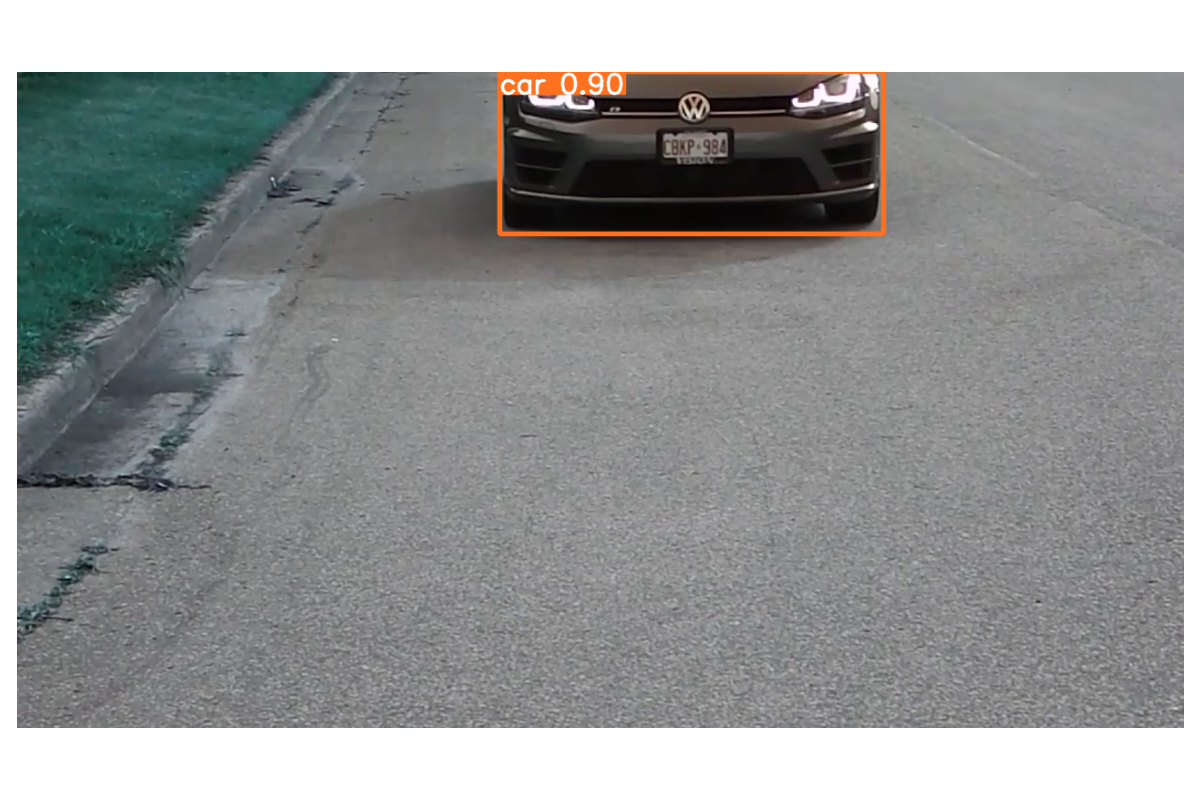

In [23]:
display_numpy_image(yolov5_results_to_numpy(yolo_lst[20][0]))

In [26]:
most_common_license_plate(alpr_lst)

'CBKP984'

In [293]:
#Pass the data into a temporary data frame

In [27]:
#Create reconstruction of the images to see how model looks
complete_vid = []
for i in range(len(yolo_lst)):
    complete_vid.append(yolov5_results_to_numpy(yolo_lst[i][0]))

In [28]:
#Save all the images to a video
image_list = complete_vid 
output_video_path = 'C:\\Users\\jacob\\Desktop\\Projects\\ANPR_Camera\\Data\\Test.mp4'
create_video(image_list, output_video_path)